# step 1 : Understand data 

In [1]:
%pip install -U pip setuptools wheel
%pip install numpy pandas matplotlib h5py



  Using cached matplotlib-3.10.6-cp310-cp310-win_amd64.whl.metadata (11 kB)
  Using cached contourpy-1.3.2-cp310-cp310-win_amd64.whl.metadata (5.5 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached fonttools-4.60.0-cp310-cp310-win_amd64.whl.metadata (113 kB)
  Using cached kiwisolver-1.4.9-cp310-cp310-win_amd64.whl.metadata (6.4 kB)
   ---------------------------------------- 0.0/12.9 MB ? eta -:--:--
    --------------------------------------- 0.3/12.9 MB ? eta -:--:--
   ------- -------------------------------- 2.4/12.9 MB 9.0 MB/s eta 0:00:02
   ----------------- ---------------------- 5.5/12.9 MB 11.6 MB/s eta 0:00:01
   -------------------------- ------------- 8.4/12.9 MB 11.8 MB/s eta 0:00:01
   ------------------------------ --------- 9.7/12.9 MB 12.3 MB/s eta 0:00:01
   ------------------------------ --------- 9.7/12.9 MB 12.3 MB/s eta 0:00:01
   ------------------------------ --------- 10.0/12.9 MB 8.0 MB/s eta 0:00:01
   ----------------------

Found 369 volumes and 57195 slice files.
Loaded metadata CSV with 57195 rows.
Loaded survival CSV with 236 rows.
Split (by patient/volume): train=258, val=55, test=56
Saved splits to C:\Users\mahdi\segmentation_model\content\data\splits_patientwise.json
[Volume 306] X shape (155, 240, 240, 4), dtype float64 -> normalized dtype float32
  per-modality mean/std after z-norm:
   - ch0: mean=0.001, std=0.944, min=-0.66, max=4.13
   - ch1: mean=0.001, std=0.944, min=-0.67, max=4.06
   - ch2: mean=0.001, std=0.944, min=-0.66, max=4.29
   - ch3: mean=0.001, std=0.944, min=-0.64, max=4.55
  tumor slices: 82 / 155 | max WT area: 4333


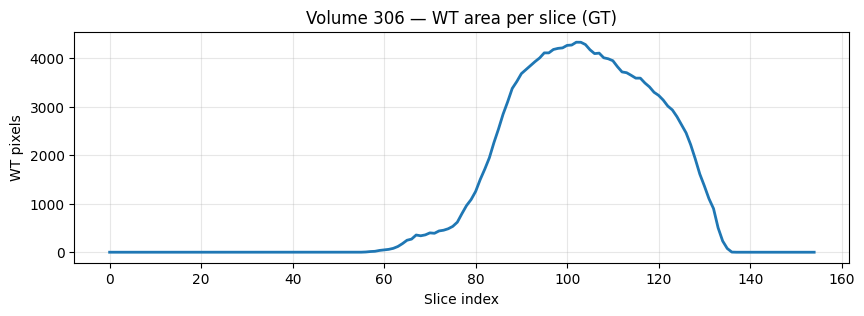

[Volume 269] X shape (155, 240, 240, 4), dtype float64 -> normalized dtype float32
  per-modality mean/std after z-norm:
   - ch0: mean=0.001, std=0.967, min=-0.63, max=4.54
   - ch1: mean=0.001, std=0.967, min=-0.63, max=4.54
   - ch2: mean=0.001, std=0.967, min=-0.64, max=4.61
   - ch3: mean=0.001, std=0.947, min=-0.61, max=4.68
  tumor slices: 44 / 155 | max WT area: 1233


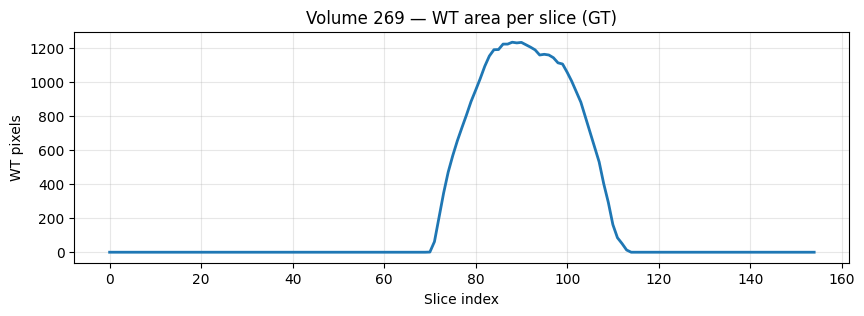

[Volume 315] X shape (155, 240, 240, 4), dtype float64 -> normalized dtype float32
  per-modality mean/std after z-norm:
   - ch0: mean=0.001, std=0.961, min=-0.66, max=4.17
   - ch1: mean=0.000, std=0.961, min=-0.63, max=4.35
   - ch2: mean=0.001, std=0.961, min=-0.66, max=4.24
   - ch3: mean=0.001, std=0.961, min=-0.65, max=4.75
  tumor slices: 44 / 155 | max WT area: 1223


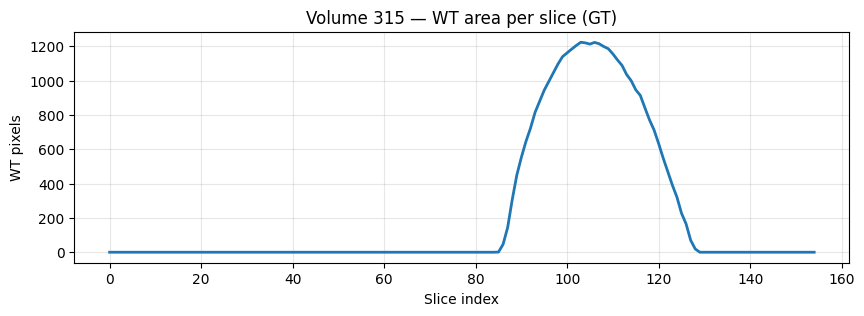

KeyboardInterrupt: 

In [ ]:
# =========================
# STEP 1: Data indexing, normalization, and patient-wise splits
# =========================

import os, re, json, math, h5py, random, warnings
from pathlib import Path
from collections import defaultdict, Counter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")

# ----------- CONFIG (edit if needed) -----------
DATA_DIR = Path(r"C:\Users\mahdi\segmentation_model\content\data")
# Folder above should contain many files like: volume_1_slice_0.h5 and the CSVs.

METADATA_CSV = DATA_DIR / "BraTS20 Training Metadata.csv"
SURVIVAL_CSV = DATA_DIR / "survival_info.csv"   # per your path

# Splits (by patient/volume)
TRAIN_FRAC, VAL_FRAC, TEST_FRAC = 0.70, 0.15, 0.15
SPLIT_SEED = 1337

# QC: how many random volumes to quickly inspect
QC_SAMPLE_N = 3
# -----------------------------------------------


# ========== 1) Index all .h5 slice files by volume ==========
h5_files = sorted([p for p in DATA_DIR.glob("*.h5") if p.name.startswith("volume_") and "_slice_" in p.name])
assert len(h5_files) > 0, f"No .h5 slice files found in {DATA_DIR}"

vol_pat = re.compile(r"volume_(\d+)_slice_(\d+)\.h5$")
by_vol = defaultdict(list)

for p in h5_files:
    m = vol_pat.match(p.name)
    if not m:
        continue
    vol_id = int(m.group(1))
    slc_id = int(m.group(2))
    by_vol[vol_id].append((slc_id, p))

# sort slices within each volume
for v in by_vol:
    by_vol[v].sort(key=lambda t: t[0])

print(f"Found {len(by_vol)} volumes and {len(h5_files)} slice files.")


# ========== 2) Read CSVs and align paths / IDs ==========
# Metadata CSV: fix the first column (it has Kaggle-style paths); we'll use only the filename
if METADATA_CSV.exists():
    meta_df = pd.read_csv(METADATA_CSV)
    # keep only the basename so we can match to local disk
    meta_df["file_name"] = meta_df["slice_path"].apply(lambda s: os.path.basename(str(s)))
    # Derive volume & slice from file_name (trusted over CSV columns if mismatch)
    m2 = meta_df["file_name"].str.extract(r"volume_(\d+)_slice_(\d+)\.h5").astype(int)
    meta_df["volume_from_name"] = m2[0]
    meta_df["slice_from_name"]  = m2[1]
    # prefer parsed columns
    meta_df["volume"] = meta_df["volume_from_name"]
    meta_df["slice"]  = meta_df["slice_from_name"]
    # build a quick lookup
    meta_lookup = meta_df.set_index(["volume","slice"]).to_dict(orient="index")
    print(f"Loaded metadata CSV with {len(meta_df)} rows.")
else:
    meta_df = None
    meta_lookup = {}
    print("Metadata CSV not found; continuing without it.")

# Survival CSV: map BraTS20_Training_XXX to volume number XXX
if SURVIVAL_CSV.exists():
    surv_df = pd.read_csv(SURVIVAL_CSV)
    surv_df["volume"] = surv_df["Brats20ID"].str.extract(r"BraTS20_Training_(\d+)").astype(int)
    surv_map = surv_df.set_index("volume").to_dict(orient="index")
    print(f"Loaded survival CSV with {len(surv_df)} rows.")
else:
    surv_df = None
    surv_map = {}
    print("Survival CSV not found; continuing without it.")


# ========== 3) Helpers to load & normalize one volume ==========
def robust_zscore_per_volume(vol_4d, eps=1e-6):
    """
    vol_4d: (S, H, W, C) float array
    Robust per-volume, per-modality z-score:
      - compute percentiles (0.5, 99.5) on non-zero voxels
      - clip, then z-score using mean/std of clipped non-zero voxels
    returns float32 array same shape
    """
    vol_4d = vol_4d.astype(np.float32, copy=True)
    S, H, W, C = vol_4d.shape
    out = np.zeros_like(vol_4d, dtype=np.float32)
    for c in range(C):
        x = vol_4d[..., c]
        nz = x != 0
        if not np.any(nz):
            out[..., c] = 0.0
            continue
        vals = x[nz]
        p_low, p_high = np.percentile(vals, [0.5, 99.5])
        x_clip = np.clip(x, p_low, p_high)
        mu = x_clip[nz].mean()
        sd = x_clip[nz].std()
        if sd < eps:
            sd = eps
        out[..., c] = (x_clip - mu) / sd
    return out

def load_volume(vol_id, expect_mask=True):
    """
    Load an entire volume into memory:
      X: (S, 240, 240, 4) float
      Y: (S, 240, 240, 3) uint8 (if expect_mask)
    """
    assert vol_id in by_vol, f"Volume {vol_id} not found"
    slice_paths = by_vol[vol_id]
    imgs, msks = [], []

    for slc_idx, p in slice_paths:
        with h5py.File(p, "r") as f:
            img = f["image"][()]   # (240,240,4)
            imgs.append(img)
            if expect_mask and "mask" in f:
                msk = f["mask"][()]  # (240,240,3)
                msks.append(msk)

    X = np.stack(imgs, axis=0)  # (S,H,W,C)
    Y = None
    if expect_mask and len(msks) == len(imgs):
        Y = np.stack(msks, axis=0).astype(np.uint8)

    return X, Y

def whole_tumor_union(Y):
    """
    Y: (S,H,W,3) binary channels [NCR/NET, ED, ET]
    returns WT mask (S,H,W) uint8
    """
    if Y is None:
        return None
    wt = (Y.sum(axis=-1) > 0).astype(np.uint8)
    return wt


# ========== 4) Build patient-wise splits ==========
all_vols = sorted(by_vol.keys())

# sanity: remove volumes that have too few slices (edge-case)
valid_vols = [v for v in all_vols if len(by_vol[v]) >= 20]
if len(valid_vols) < len(all_vols):
    print(f"Filtered out {len(all_vols)-len(valid_vols)} volumes with <20 slices.")

rng = random.Random(SPLIT_SEED)
shuffled = valid_vols.copy()
rng.shuffle(shuffled)

n_total = len(shuffled)
n_train = int(round(TRAIN_FRAC * n_total))
n_val   = int(round(VAL_FRAC   * n_total))
n_test  = n_total - n_train - n_val
if n_test <= 0:
    n_test = max(1, n_total - (n_train + n_val))

train_vols = sorted(shuffled[:n_train])
val_vols   = sorted(shuffled[n_train:n_train+n_val])
test_vols  = sorted(shuffled[n_train+n_val:])

print(f"Split (by patient/volume): train={len(train_vols)}, val={len(val_vols)}, test={len(test_vols)}")

# save splits for reproducibility
splits_path = DATA_DIR / "splits_patientwise.json"
with open(splits_path, "w") as f:
    json.dump({"seed": SPLIT_SEED,
               "train": train_vols,
               "val": val_vols,
               "test": test_vols}, f, indent=2)
print(f"Saved splits to {splits_path}")


# ========== 5) Quick QC on a few random volumes ==========
def qc_volume(vol_id, plot=True):
    X, Y = load_volume(vol_id, expect_mask=True)
    S, H, W, C = X.shape
    Xn = robust_zscore_per_volume(X)

    print(f"[Volume {vol_id}] X shape {X.shape}, dtype {X.dtype} -> normalized dtype {Xn.dtype}")
    print(f"  per-modality mean/std after z-norm:")
    for c in range(C):
        xm = Xn[...,c]
        # compute stats on non-zero to be meaningful
        nz = xm != 0
        mu = xm[nz].mean() if np.any(nz) else 0.0
        sd = xm[nz].std()  if np.any(nz) else 0.0
        print(f"   - ch{c}: mean={mu:.3f}, std={sd:.3f}, min={xm.min():.2f}, max={xm.max():.2f}")

    if Y is not None:
        WT = whole_tumor_union(Y)
        areas = WT.reshape(S, -1).sum(axis=1)
        print(f"  tumor slices: {(areas>0).sum()} / {S} | max WT area: {int(areas.max())}")
        if plot:
            plt.figure(figsize=(10,3))
            plt.plot(areas, lw=2)
            plt.title(f"Volume {vol_id} — WT area per slice (GT)")
            plt.xlabel("Slice index"); plt.ylabel("WT pixels")
            plt.grid(alpha=0.3)
            plt.show()
    else:
        print("  No masks found in .h5 (expect_mask=True but missing 'mask').")

# Sample a few volumes for QC
qc_ids = rng.sample(valid_vols, k=min(QC_SAMPLE_N, len(valid_vols)))
for vid in qc_ids:
    qc_volume(vid, plot=True)


# ========== 6) Summarize per-volume stats (optional, but handy) ==========
stats_rows = []
for vid in valid_vols:
    X, Y = load_volume(vid, expect_mask=True)
    S = X.shape[0]
    WT = whole_tumor_union(Y) if Y is not None else None
    tumor_slices = int((WT.reshape(S, -1).sum(axis=1) > 0).sum()) if WT is not None else np.nan
    max_area = int(WT.reshape(S, -1).sum(axis=1).max()) if WT is not None else np.nan
    best_idx = int(np.argmax(WT.reshape(S, -1).sum(axis=1))) if WT is not None else np.nan

    row = {"volume": vid, "num_slices": S, "tumor_slices": tumor_slices,
           "max_WT_area": max_area, "best_slice_idx_gt": best_idx}

    # attach survival if available
    if vid in surv_map:
        row.update(surv_map[vid])
    stats_rows.append(row)

stats_df = pd.DataFrame(stats_rows).sort_values("volume")
stats_csv_path = DATA_DIR / "volume_stats.csv"
stats_df.to_csv(stats_csv_path, index=False)
print(f"Saved per-volume stats to {stats_csv_path}")

display_cols = [c for c in ["volume","num_slices","tumor_slices","max_WT_area","best_slice_idx_gt","Age","Survival_days","Extent_of_Resection"] if c in stats_df.columns]
display(stats_df[display_cols].head(10))


The error is because I interrupted this part manually because It takes long time and It's optional 

# Step 2: Train segmentation model

In [ ]:
# A1) (once) install deps in THIS env/kernel
%pip install -U pip
%pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
%pip install h5py numpy pandas matplotlib scikit-image opencv-python-headless tqdm




Note: you may need to restart the kernel to use updated packages.
^C
Note: you may need to restart the kernel to use updated packages.


In [1]:
# A2) check GPU
import torch, sys
print("torch:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
print("torch built with CUDA:", torch.version.cuda)
if torch.cuda.is_available():
    print("GPU:", torch.cuda.get_device_name(0))
else:
    print("Running on CPU (will be slower).")

torch: 2.5.1+cu121
CUDA available: True
torch built with CUDA: 12.1
GPU: NVIDIA GeForce RTX 4060 Laptop GPU


In [2]:
print(torch.version.cuda)

12.1


In [ ]:
# =========================
# STEP 3: Train "Seg-AllSlices" (2D UNet) on your .h5 slices
# =========================

import os, re, json, math, h5py, random
from pathlib import Path
from collections import defaultdict

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

# -------- CONFIG --------
DATA_DIR = Path(r"C:\Users\mahdi\segmentation_model\content\data")

SPLITS_JSON = DATA_DIR / "splits_patientwise.json"  # created in Step 1
METADATA_CSV = DATA_DIR / "BraTS20 Training Metadata.csv"  # optional (for oversampling tumor)

BATCH_SIZE   = 8
LR           = 1e-3
EPOCHS       = 10                 # start small to verify the loop; you can raise later
NUM_WORKERS  = 0                  # set >0 if your Windows build can handle multiprocessing
SAVE_PATH    = DATA_DIR / "seg_all_slices_unet.pt"
DEVICE       = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", DEVICE)

# ---- Index .h5 files by volume ----
h5_files = sorted([p for p in DATA_DIR.glob("*.h5") if p.name.startswith("volume_") and "_slice_" in p.name])
pat = re.compile(r"volume_(\d+)_slice_(\d+)\.h5$")
by_vol = defaultdict(list)
for p in h5_files:
    m = pat.match(p.name)
    if m:
        vol = int(m.group(1)); slc = int(m.group(2))
        by_vol[vol].append((slc, p))
for v in by_vol: by_vol[v].sort(key=lambda t: t[0])

assert SPLITS_JSON.exists(), "splits_patientwise.json not found. Run Step 1 first."
splits = json.loads(SPLITS_JSON.read_text())
train_vols, val_vols, test_vols = splits["train"], splits["val"], splits["test"]
print(f"Volumes: train={len(train_vols)} val={len(val_vols)} test={len(test_vols)}")

# ---- (Optional) load metadata for oversampling tumor slices ----
tumor_weight = {}
if METADATA_CSV.exists():
    meta_df = pd.read_csv(METADATA_CSV)
    meta_df["file_name"] = meta_df["slice_path"].apply(lambda s: os.path.basename(str(s)))
    m2 = meta_df["file_name"].str.extract(r"volume_(\d+)_slice_(\d+)\.h5").astype(int)
    meta_df["volume"] = m2[0]; meta_df["slice"] = m2[1]
    # simple rule: if target==1 (has tumor), give higher sample weight
    for (_, row) in meta_df.iterrows():
        tumor_weight[(int(row["volume"]), int(row["slice"]))] = 3.0 if row.get("target", 0)==1 else 1.0
else:
    print("Metadata CSV not found → using uniform sampling.")

# ---- Normalization (robust z-score per SLICE; fast & OK for training) ----
def robust_z_per_slice(img4):
    # img4: (H,W,4) float
    out = np.zeros_like(img4, dtype=np.float32)
    for c in range(img4.shape[-1]):
        x = img4[...,c]
        nz = x!=0
        if not np.any(nz):
            out[...,c] = 0.0
            continue
        vals = x[nz]
        p1, p99 = np.percentile(vals, [0.5, 99.5])
        xc = np.clip(x, p1, p99)
        mu, sd = xc[nz].mean(), xc[nz].std()
        if sd < 1e-6: sd = 1e-6
        out[...,c] = (xc - mu)/sd
    return out

# ---- Dataset that yields individual slices ----
class SliceDataset(Dataset):
    def __init__(self, volumes, by_vol_map):
        self.samples = []  # list of (vol, slc, path)
        for v in volumes:
            for slc, p in by_vol_map[v]:
                self.samples.append((v, slc, p))
        print(f"Total slices: {len(self.samples)}")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        v, s, p = self.samples[idx]
        with h5py.File(p, "r") as f:
            img = f["image"][()]            # (240,240,4) float
            msk = f["mask"][()]            # (240,240,3) uint8 binary
        img = robust_z_per_slice(img).astype(np.float32)          # (H,W,4)
        msk = (msk > 0).astype(np.float32)                        # (H,W,3)
        # to torch shape [C,H,W]
        img_t = torch.from_numpy(img).permute(2,0,1).contiguous() # [4,240,240]
        msk_t = torch.from_numpy(msk).permute(2,0,1).contiguous() # [3,240,240]
        return img_t, msk_t, (v, s)

# ---- Build datasets & (optionally) a weighted sampler for tumor slices ----
train_ds = SliceDataset(train_vols, by_vol)
val_ds   = SliceDataset(val_vols, by_vol)

sampler = None
if tumor_weight:
    weights = []
    for v,s,_ in train_ds.samples:
        weights.append(tumor_weight.get((v,s), 1.0))
    sampler = WeightedRandomSampler(weights=weights, num_samples=len(weights), replacement=True)
    print("Using WeightedRandomSampler (tumor oversampling).")

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=(sampler is None),
                          sampler=sampler, num_workers=NUM_WORKERS, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=NUM_WORKERS, pin_memory=True)

# ---- Small UNet (3-class, multi-label) ----
class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
        )
    def forward(self, x): return self.block(x)

class UNetSmall(nn.Module):
    def __init__(self, in_ch=4, out_ch=3):
        super().__init__()
        self.d1 = DoubleConv(in_ch, 32)
        self.p1 = nn.MaxPool2d(2)
        self.d2 = DoubleConv(32, 64)
        self.p2 = nn.MaxPool2d(2)
        self.d3 = DoubleConv(64, 128)
        self.p3 = nn.MaxPool2d(2)
        self.b  = DoubleConv(128, 256)
        self.u3 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.c3 = DoubleConv(256, 128)
        self.u2 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.c2 = DoubleConv(128, 64)
        self.u1 = nn.ConvTranspose2d(64, 32, 2, stride=2)
        self.c1 = DoubleConv(64, 32)
        self.out = nn.Conv2d(32, out_ch, 1)   # logits

    def forward(self, x):
        c1 = self.d1(x)        # 240
        c2 = self.d2(self.p1(c1))  # 120
        c3 = self.d3(self.p2(c2))  # 60
        b  = self.b(self.p3(c3))   # 30
        x  = self.u3(b)
        x  = self.c3(torch.cat([x, c3], dim=1))
        x  = self.u2(x)
        x  = self.c2(torch.cat([x, c2], dim=1))
        x  = self.u1(x)
        x  = self.c1(torch.cat([x, c1], dim=1))
        return self.out(x)  # [B,3,240,240]

# ---- Loss: BCEWithLogits + SoftDice (per class) ----
class BCEDiceLoss(nn.Module):
    def __init__(self, smooth=1.0):
        super().__init__()
        self.bce = nn.BCEWithLogitsLoss()
        self.smooth = smooth
    def forward(self, logits, target):
        bce = self.bce(logits, target)
        probs = torch.sigmoid(logits)
        num = 2.0 * (probs*target).sum(dim=(2,3)) + self.smooth
        den = (probs*probs).sum(dim=(2,3)) + (target*target).sum(dim=(2,3)) + self.smooth
        dice = 1.0 - (num/den).mean(dim=1)            # per-sample
        return bce + dice.mean()

@torch.no_grad()
def dice_per_class(logits, target, thr=0.5, eps=1e-6):
    probs = torch.sigmoid(logits)
    pred  = (probs > thr).float()
    inter = (pred*target).sum(dim=(0,2,3))
    den   = pred.sum(dim=(0,2,3)) + target.sum(dim=(0,2,3))
    return (2*inter + eps)/(den + eps)   # tensor of size [3]

# ---- Train / Val loops ----
model = UNetSmall(in_ch=4, out_ch=3).to(DEVICE)
opt = torch.optim.Adam(model.parameters(), lr=LR)
loss_fn = BCEDiceLoss()

def run_epoch(loader, train=True):
    model.train(train)
    tot_loss, tot_batches = 0.0, 0
    dsum = torch.zeros(3, device=DEVICE)
    for imgs, msks, _ in loader:
        imgs = imgs.to(DEVICE, non_blocking=True)
        msks = msks.to(DEVICE, non_blocking=True)
        if train:
            opt.zero_grad()
        logits = model(imgs)
        loss = loss_fn(logits, msks)
        if train:
            loss.backward()
            opt.step()
        tot_loss += float(loss.item())
        dsum += dice_per_class(logits, msks)
        tot_batches += 1
    return tot_loss/tot_batches, (dsum/tot_batches).detach().cpu().numpy()

best_val = float("inf")
for ep in range(1, EPOCHS+1):
    tr_loss, tr_dice = run_epoch(train_loader, train=True)
    va_loss, va_dice = run_epoch(val_loader,   train=False)
    print(f"[{ep:02d}/{EPOCHS}] "
          f"train loss={tr_loss:.4f} dice={tr_dice} | "
          f"val loss={va_loss:.4f} dice={va_dice}")
    if va_loss < best_val:
        best_val = va_loss
        torch.save({"model": model.state_dict(),
                    "epoch": ep}, SAVE_PATH)
        print(f"  -> saved checkpoint to {SAVE_PATH}")

print("Training done.")

# ---- Inference helper: predict all slices in a volume & pick best slice ----
@torch.no_grad()
def predict_volume_and_best_slice(volume_id, threshold=0.5):
    # get ordered slice paths
    slices = by_vol[volume_id]
    areas = []
    per_slice_masks = []
    model.eval()
    for _, p in slices:
        with h5py.File(p, "r") as f:
            img = f["image"][()]
        img = robust_z_per_slice(img).astype(np.float32)
        img_t = torch.from_numpy(img).permute(2,0,1)[None].to(DEVICE)
        logits = model(img_t)                      # [1,3,H,W]
        probs  = torch.sigmoid(logits)[0]          # [3,H,W]
        binmsk = (probs > threshold).float()       # [3,H,W]
        wt = (binmsk.sum(dim=0) > 0).float()       # [H,W]
        areas.append(int(wt.sum().item()))
        per_slice_masks.append(binmsk.cpu().numpy())
    # simple smoothing (moving average) before argmax
    a = np.array(areas, dtype=np.float32)
    if len(a) >= 5:
        k = 5
        kernel = np.ones(k)/k
        a_smooth = np.convolve(a, kernel, mode="same")
    else:
        a_smooth = a
    best_idx = int(a_smooth.argmax())
    return best_idx, areas, per_slice_masks

# Example: run on the first test volume to get the best slice index
if len(test_vols) > 0:
    ckpt = torch.load(SAVE_PATH, map_location=DEVICE)
    model.load_state_dict(ckpt["model"])
    vid = test_vols[0]
    best_idx, areas, _ = predict_volume_and_best_slice(vid, threshold=0.5)
    print(f"[Test volume {vid}] best slice index (predicted) = {best_idx}  (total slices={len(areas)})")


Device: cuda
Volumes: train=258 val=55 test=56
Total slices: 39990
Total slices: 8525
Using WeightedRandomSampler (tumor oversampling).
[01/10] train loss=0.3297 dice=[0.44083604 0.65542614 0.69546896] | val loss=0.1960 dice=[0.7614296  0.68894935 0.79791415]
  -> saved checkpoint to C:\Users\mahdi\segmentation_model\content\data\seg_all_slices_unet.pt
[02/10] train loss=0.2490 dice=[0.5065005 0.7044554 0.7535225] | val loss=0.1592 dice=[0.804579  0.7543647 0.8447491]
  -> saved checkpoint to C:\Users\mahdi\segmentation_model\content\data\seg_all_slices_unet.pt
[03/10] train loss=0.2252 dice=[0.5708647 0.7360584 0.7714818] | val loss=0.1657 dice=[0.80516464 0.7087805  0.83445597]
[04/10] train loss=0.2148 dice=[0.5948121 0.7515824 0.7849865] | val loss=0.1763 dice=[0.7680033 0.7128452 0.8072743]
[05/10] train loss=0.2067 dice=[0.6148771  0.76153    0.78849375] | val loss=0.1701 dice=[0.8028807  0.68233955 0.8548261 ]
[06/10] train loss=0.1984 dice=[0.6373664  0.76827025 0.79759115] | v

C:\Users\mahdi\AppData\Local\Temp\ipykernel_28572\1533174636.py:255: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(SAVE_PATH, map_location=DEVICE)


[Test volume 9] best slice index (predicted) = 67  (total slices=155)


In [5]:
import torch
from pathlib import Path

DATA_DIR = Path(r"C:\Users\mahdi\OneDrive\Desktop\Mitacs project\BraTS2020_training_data\content\data")

# Save trained model weights
torch.save(model.state_dict(), DATA_DIR / "unet_model.pth")


In [12]:
# one-time export (after training & loading best weights)
model.eval()
example = torch.randn(1, 4, 240, 240).to(DEVICE)
traced = torch.jit.trace(model, example)
traced.save(str(DATA_DIR / "unet_traced.pt"))


# Visualisation of test segmentation

In [3]:
%pip install numpy pandas matplotlib h5py

Note: you may need to restart the kernel to use updated packages.


Device: cuda
Test volumes: 56
Loaded weights from: C:\Users\mahdi\OneDrive\Desktop\Mitacs project\BraTS2020_training_data\content\data\unet_model.pth


C:\Users\mahdi\AppData\Local\Temp\ipykernel_11784\1661297681.py:92: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(WEIGHTS_PATH, map_location=DEVICE)


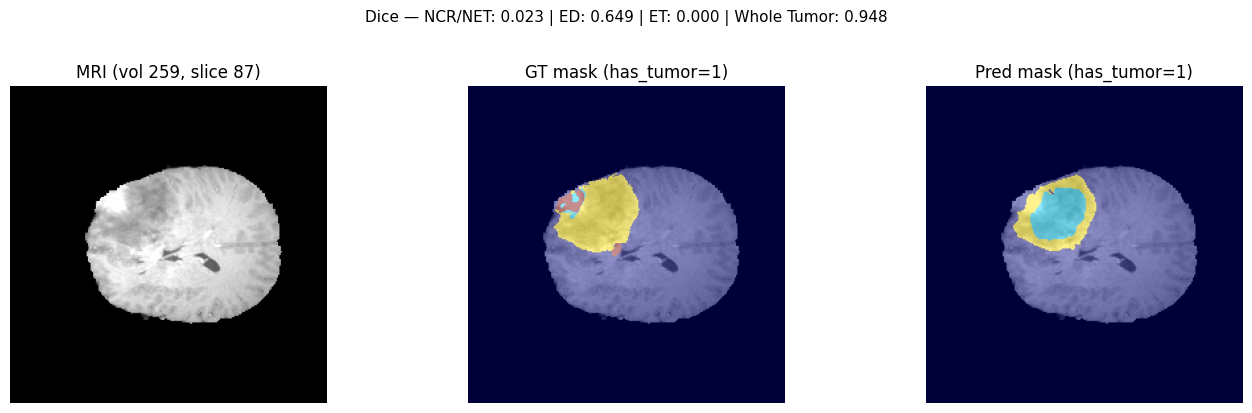

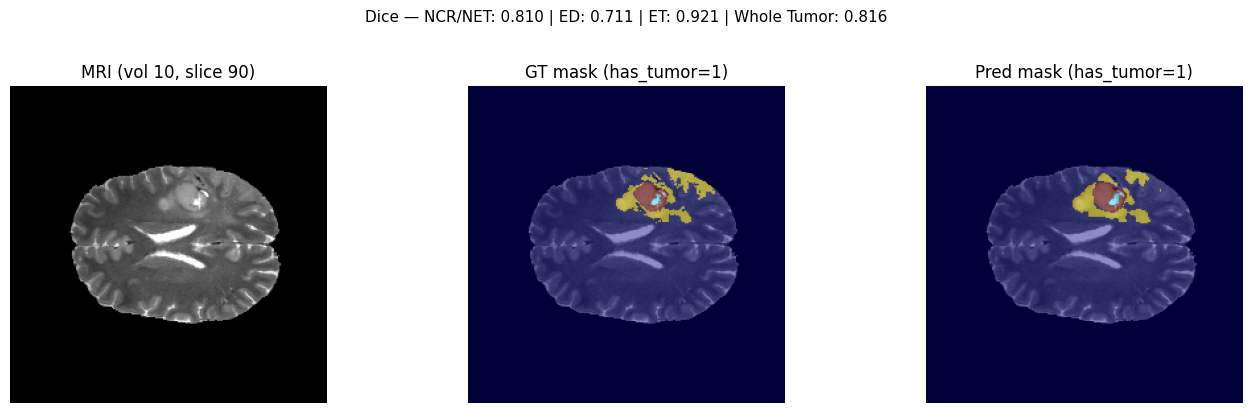

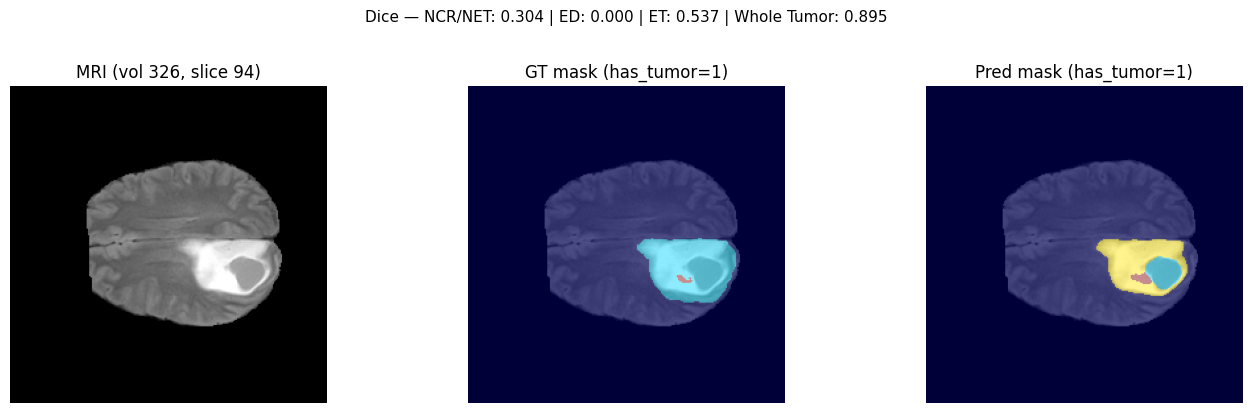

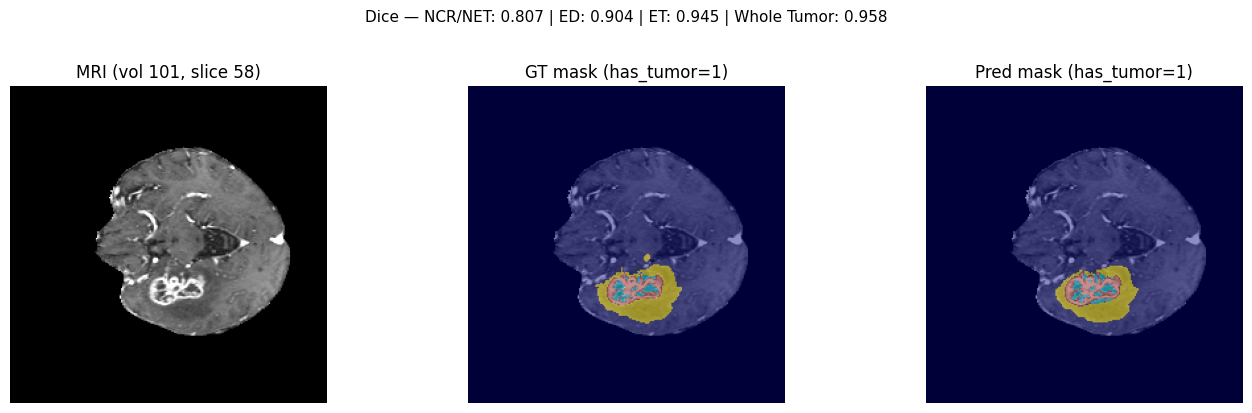

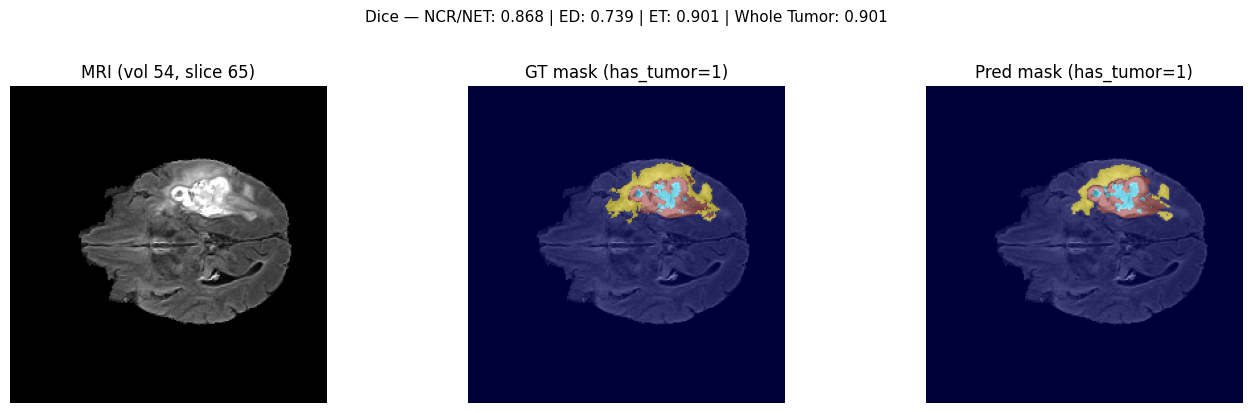

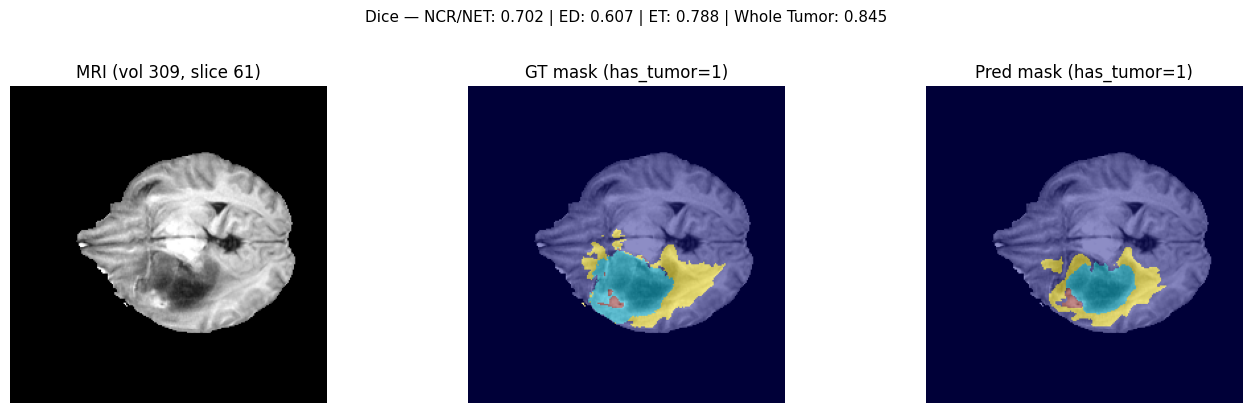

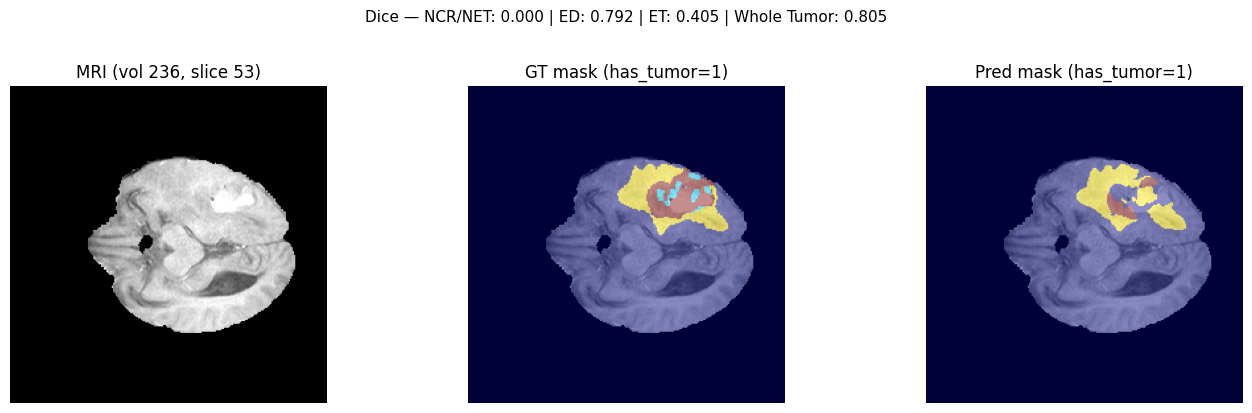

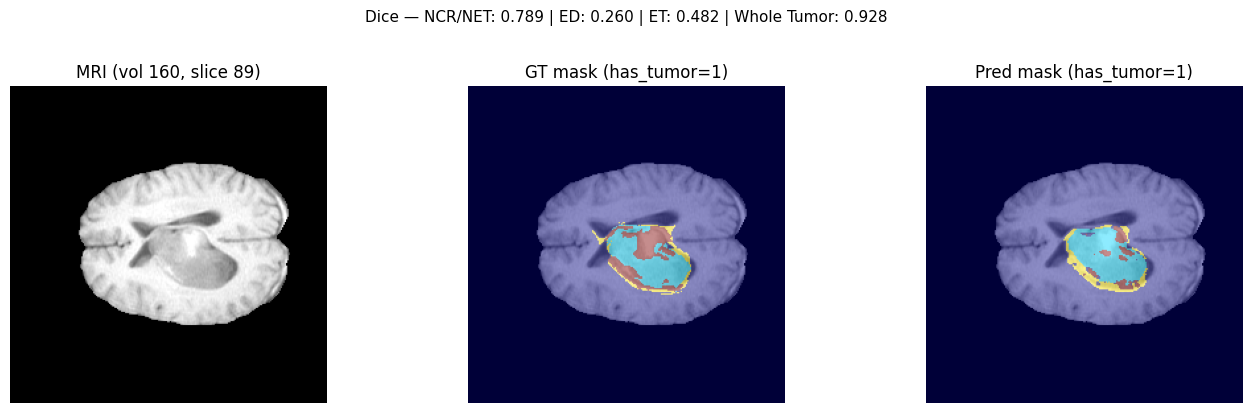

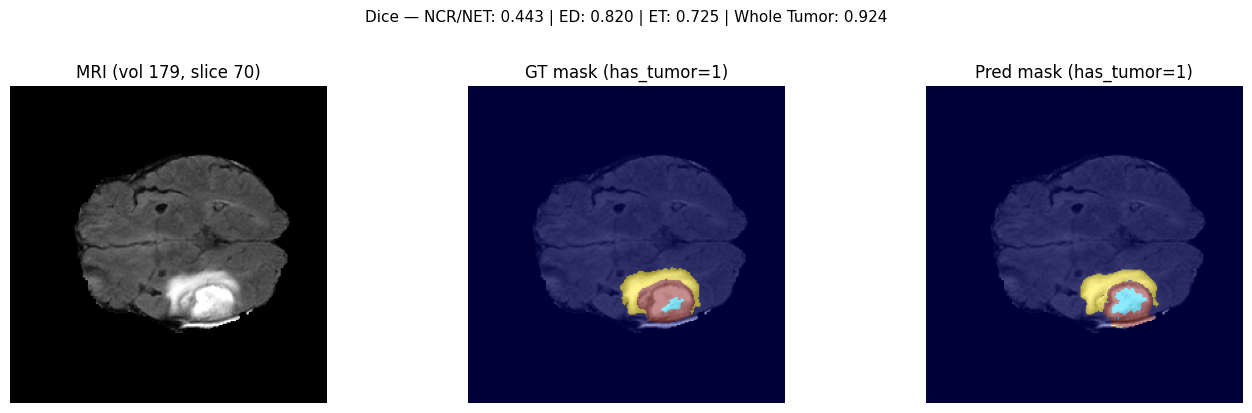

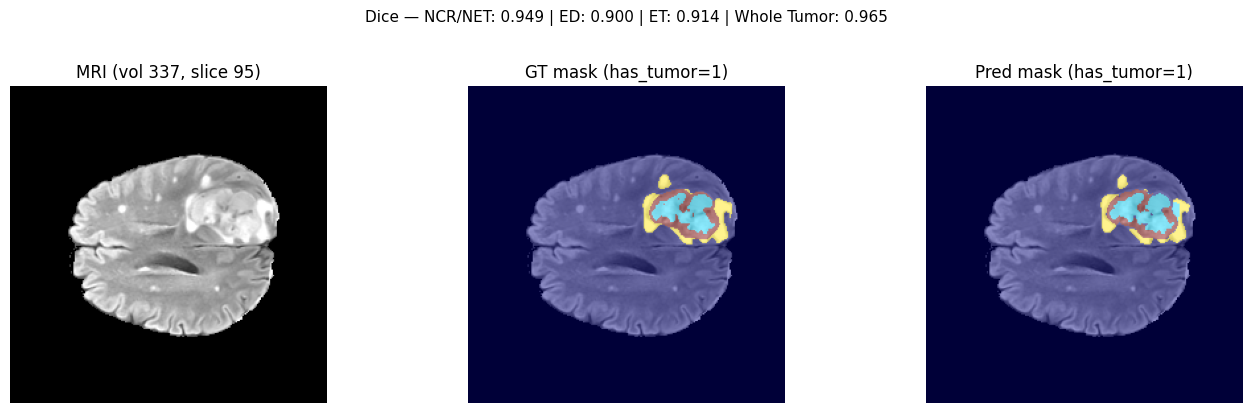

In [9]:
# ============================================
# Use saved weights -> visualize best-slice preds for 10 random test volumes
# ============================================

import os, re, json, random, h5py
from pathlib import Path
from collections import defaultdict

import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

# ---------- CONFIG ----------
DATA_DIR    = Path(r"C:\Users\mahdi\OneDrive\Desktop\Mitacs project\BraTS2020_training_data\content\data")
SPLITS_JSON = DATA_DIR / "splits_patientwise.json"
WEIGHTS_PATH = DATA_DIR / "unet_model.pth"   # <— your saved weights
DEVICE      = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", DEVICE)

# ---------- Re-index .h5 files by volume ----------
pat = re.compile(r"volume_(\d+)_slice_(\d+)\.h5$")
h5_files = sorted([p for p in DATA_DIR.glob("*.h5") if pat.match(p.name)])
by_vol = defaultdict(list)
for p in h5_files:
    m = pat.match(p.name)
    vid, slc = int(m.group(1)), int(m.group(2))
    by_vol[vid].append((slc, p))
for v in by_vol:
    by_vol[v].sort(key=lambda t: t[0])

assert SPLITS_JSON.exists(), "splits_patientwise.json not found. Run Step 1 first."
splits = json.loads(SPLITS_JSON.read_text())
test_vols = list(splits["test"])
print(f"Test volumes: {len(test_vols)}")

# ---------- Normalization (same as training) ----------
def robust_z_per_slice(img4):
    out = np.zeros_like(img4, dtype=np.float32)
    for c in range(img4.shape[-1]):
        x = img4[..., c]
        nz = x != 0
        if not np.any(nz):
            out[..., c] = 0.0
            continue
        vals = x[nz]
        p1, p99 = np.percentile(vals, [0.5, 99.5])
        xc = np.clip(x, p1, p99)
        mu, sd = xc[nz].mean(), xc[nz].std()
        if sd < 1e-6: sd = 1e-6
        out[..., c] = (xc - mu) / sd
    return out

# ---------- Model (same architecture as training) ----------
class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
        )
    def forward(self, x):
        return self.block(x)

class UNetSmall(nn.Module):
    def __init__(self, in_ch=4, out_ch=3):
        super().__init__()
        self.d1 = DoubleConv(in_ch, 32); self.p1 = nn.MaxPool2d(2)
        self.d2 = DoubleConv(32, 64);    self.p2 = nn.MaxPool2d(2)
        self.d3 = DoubleConv(64, 128);   self.p3 = nn.MaxPool2d(2)
        self.b  = DoubleConv(128, 256)
        self.u3 = nn.ConvTranspose2d(256, 128, 2, stride=2); self.c3 = DoubleConv(256, 128)
        self.u2 = nn.ConvTranspose2d(128, 64,  2, stride=2); self.c2 = DoubleConv(128, 64)
        self.u1 = nn.ConvTranspose2d(64,  32,  2, stride=2); self.c1 = DoubleConv(64,  32)
        self.out = nn.Conv2d(32, out_ch, 1)   # logits
    def forward(self, x):
        c1 = self.d1(x)
        c2 = self.d2(self.p1(c1))
        c3 = self.d3(self.p2(c2))
        b  = self.b(self.p3(c3))
        x  = self.u3(b); x = self.c3(torch.cat([x, c3], dim=1))
        x  = self.u2(x); x = self.c2(torch.cat([x, c2], dim=1))
        x  = self.u1(x); x = self.c1(torch.cat([x, c1], dim=1))
        return self.out(x)               # [B,3,240,240]

model = UNetSmall(in_ch=4, out_ch=3).to(DEVICE)
assert WEIGHTS_PATH.exists(), f"Missing weights: {WEIGHTS_PATH}"
state = torch.load(WEIGHTS_PATH, map_location=DEVICE)
model.load_state_dict(state)
model.eval()
print("Loaded weights from:", WEIGHTS_PATH)

# ---------- Dice metric (safe) ----------
def dice_coef(pred, target, eps=1e-6):
    # pred/target: binary tensors same shape
    inter = (pred * target).sum()
    den   = pred.sum() + target.sum()
    if den.item() == 0:
        return torch.tensor(1.0)  # both empty → Dice=1 by convention
    return (2.0 * inter + eps) / (den + eps)

# ---------- Predict all slices & choose best slice by predicted WT area ----------
@torch.no_grad()
def predict_volume_and_best_slice(volume_id, threshold=0.5):
    slices = by_vol[volume_id]
    areas = []
    per_slice_masks = []  # list of [3,H,W] binary (numpy)
    for _, p in slices:
        with h5py.File(p, "r") as f:
            img = f["image"][()]  # (H,W,4)
        img_n = robust_z_per_slice(img).astype(np.float32)
        img_t = torch.from_numpy(img_n).permute(2,0,1)[None].to(DEVICE)  # [1,4,H,W]
        logits = model(img_t)                      # [1,3,H,W]
        probs  = torch.sigmoid(logits)[0]          # [3,H,W]
        binmsk = (probs > threshold).float()       # [3,H,W]
        wt = (binmsk.sum(dim=0) > 0).float()       # [H,W]
        areas.append(int(wt.sum().item()))
        per_slice_masks.append(binmsk.cpu().numpy())
    a = np.array(areas, dtype=np.float32)
    if len(a) >= 5:
        a = np.convolve(a, np.ones(5)/5, mode="same")
    best_idx = int(a.argmax())
    return best_idx, areas, per_slice_masks

def choose_best_channel(img4):
    # choose channel with highest std for background display
    stds = [img4[...,c].std() for c in range(img4.shape[-1])]
    return int(np.argmax(stds))

# ---------- Visualize random 10 test volumes ----------
@torch.no_grad()
def visualize_predictions_random(test_vols, num_samples=10, threshold=0.5):
    n = min(num_samples, len(test_vols))
    chosen_vols = random.sample(list(test_vols), n)
    class_names = ["NCR/NET", "ED", "ET"]
    for vid in chosen_vols:
        best_idx, areas, per_slice_masks = predict_volume_and_best_slice(vid, threshold)
        slice_id, p = by_vol[vid][best_idx]  # file for that best slice

        with h5py.File(p, "r") as f:
            img  = f["image"][()]     # (H,W,4)
            true = f["mask"][()].astype(np.uint8)  # (H,W,3)

        # preprocess for display
        img_n = robust_z_per_slice(img).astype(np.float32)
        ch = choose_best_channel(img_n)
        bg = img_n[..., ch]

        gt_mask   = (true > 0).astype(np.float32).transpose(2,0,1)       # [3,H,W]
        pred_mask = per_slice_masks[best_idx].astype(np.float32)          # [3,H,W]

        gt_wt   = (gt_mask.sum(axis=0) > 0).astype(np.float32)            # [H,W]
        pred_wt = (pred_mask.sum(axis=0) > 0).astype(np.float32)          # [H,W]

        # Dice per class + whole-tumor
        dices = []
        for c in range(3):
            d = dice_coef(torch.tensor(pred_mask[c]), torch.tensor(gt_mask[c]))
            dices.append(float(d))
        wt_dice = float(dice_coef(torch.tensor(pred_wt), torch.tensor(gt_wt)))

        # label maps (0 background, 1..3 classes)
        gt_lbl = gt_mask.argmax(axis=0) + 1
        gt_lbl[gt_mask.sum(axis=0) == 0] = 0
        pr_lbl = pred_mask.argmax(axis=0) + 1
        pr_lbl[pred_mask.sum(axis=0) == 0] = 0

        # tumor presence flags
        gt_has = int(gt_wt.sum() > 0)
        pr_has = int(pred_wt.sum() > 0)

        # --- plot ---
        plt.figure(figsize=(14,4))
        plt.subplot(1,3,1)
        plt.imshow(bg, cmap="gray")
        plt.title(f"MRI (vol {vid}, slice {best_idx})")
        plt.axis("off")

        plt.subplot(1,3,2)
        plt.imshow(bg, cmap="gray")
        plt.imshow(gt_lbl, cmap="jet", alpha=0.45, vmin=0, vmax=3)
        plt.title(f"GT mask (has_tumor={gt_has})")
        plt.axis("off")

        plt.subplot(1,3,3)
        plt.imshow(bg, cmap="gray")
        plt.imshow(pr_lbl, cmap="jet", alpha=0.45, vmin=0, vmax=3)
        plt.title(f"Pred mask (has_tumor={pr_has})")
        plt.axis("off")

        txt = " | ".join([f"{name}: {dices[i]:.3f}" for i, name in enumerate(class_names)])
        plt.suptitle(f"Dice — {txt} | Whole Tumor: {wt_dice:.3f}", y=1.02, fontsize=11)
        plt.tight_layout()
        plt.show()

# ---- Run it
visualize_predictions_random(test_vols, num_samples=10, threshold=0.5)
